# Before you start with this Data Preparation Notebook

This notebook is part of the Vectice tutorial project notebook series. It illustrates how to log the assets documented in the "Data Preparation" phase of the **"Tutorial: Forecast in store-unit sales** project you can find in your personal Vectice workspace.

### Pre-requisites:
Before using this notebook you will need:
* An account in Vectice
* An API token to connect to Vectice through the APIs
* The Phase Id of the project where you want to log your work

Refer to Vectice Tutorial Guide for more detailed instructions: https://docs.vectice.com/getting-started/tutorial


### Other Resources
*   Vectice Documentation: https://docs.vectice.com/ </br>
*   Vectice API documentation: https://api-docs.vectice.com/

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Install the latest Vectice Python client library

In [ ]:
%pip install --q vectice -U

## Get started by connecting to Vectice

In [10]:
import vectice

vec = vectice.connect(api_token="Er1z6v19n.pLVDjaWp34dw0XNG7ZzMxEr1z6v19nmObBP6goy2YRQJ8vlkAe") #Paste your API token

Welcome, anell. You`re now successfully connected to Vectice.

To access your personal workspace, use connection.my_workspace
To access a specific workspace, use connection.workspace(Workspace ID)
To get a list of workspaces you can access and their IDs, use connection.list_workspaces()

If you are using a notebook you can call the help by using a Vectice returned object with the builtin notebook "?":
>> connection?

If you are using an IDE you can call the help() method on any object returned by Vectice:
>> help(connection)

For quick access to the list of workspaces in the Vectice web app, visit:
https://app.vectice.com/workspaces


## Specify which project phase you want to document
In Vectice UI, navigate to your personal workspace inside your default Tutorial project go to the Data Preparation phase and copy paste your Phase Id below.

In [13]:
phase = vec.phase("PHA-3297") #Put your own Data Preparation Phase ID

Phase 'Data Preparation' successfully retrieved."

For quick access to the Phase in the Vectice web app, visit:
https://app.vectice.com/browse/phase/PHA-3297


## Next we are going to create an iteration
An iteration allows you to organize your work in repeatable sequences of steps. You can have multiple iteration within a phase

In [14]:
prep_iteration = phase.create_iteration()

New Iteration number 2 created.

For quick access to the Iteration in the Vectice web app, visit:
https://app.vectice.com/browse/iteration/ITR-1247


In [15]:
df_initial = pd.read_csv("https://raw.githubusercontent.com/vectice/GettingStarted/main/23.2/tutorial/SampleSuperstore.csv", converters = {'Postal Code': str})
df_initial.to_csv("SampleSuperstore.csv", index=False)

## Create Vertex AI Dataset

In [9]:
from google.cloud import aiplatform

aiplatform.init(project="tries-and-spikes", location="us-central1")

dataset = aiplatform.TabularDataset.create_from_dataframe(
    df_initial,
    display_name="ProductSales Origin",
    staging_path="bq://tries-and-spikes.tutorial.productsales-origin"
)

dataset.wait()

print(f'\tDataset: "{dataset.display_name}"')
print(f'\tname: "{dataset.resource_name}"')

Creating TabularDataset
Create TabularDataset backing LRO: projects/599225543291/locations/us-central1/datasets/5798065661867458560/operations/4884091329878949888
TabularDataset created. Resource name: projects/599225543291/locations/us-central1/datasets/5798065661867458560
To use this TabularDataset in another session:
ds = aiplatform.TabularDataset('projects/599225543291/locations/us-central1/datasets/5798065661867458560')
	Dataset: "ProductSales Origin"
	name: "projects/599225543291/locations/us-central1/datasets/5798065661867458560"


## Log your origin dataset

In [20]:
from google.cloud import bigquery

bq_client = bigquery.Client()

origin_ds = vectice.BigQueryResource("tries-and-spikes.tutorial.productsales-origin", df_initial, bq_client)

In [21]:
origin_dataset = vectice.Dataset.origin(
    name="ProductSales Origin",
    resource=origin_ds, 
)

In [22]:
prep_iteration.step_select_data = origin_dataset

New Version: 'Version 2' of Dataset: 'ProductSales Origin' added to Step: Select Data
Attachments: None
Link to Step: https://app.vectice.com/browse/iteration/ITR-1247



## Apply transformation to your origin dataset 

In [24]:
def wrangle(df):
    
    #Reducing Cardinality
    top_ten_cities=df["City"].value_counts().head(10).index
    df["City"]=df["City"].apply(lambda c: c if c in top_ten_cities else "others")
    top_ten_states=df["State"].value_counts().head(10).index
    df["State"]=df["State"].apply(lambda c: c if c in top_ten_states else "others")
    
    ## Dealing with Outliers
    q1,q2 =df["Profit"].quantile([0.1,0.9])
    df=df[df["Profit"].between(q1,q2)]
    
    
    return df

In [25]:
df_cleaned = wrangle(df_initial)
df_cleaned.describe()

,Sales,Quantity,Discount,Profit
count,7994.000000,7994.000000,7994.000000,7994.000000
mean,98.123799,3.558419,0.131893,15.795750
std,178.131556,2.083735,0.182274,20.670667
min,0.444000,1.000000,0.000000,-15.466600
25%,14.016000,2.000000,0.000000,2.957400
50%,36.328000,3.000000,0.000000,8.666500
75%,105.520000,5.000000,0.200000,22.200000
max,4164.050000,14.000000,0.800000,89.222400


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  


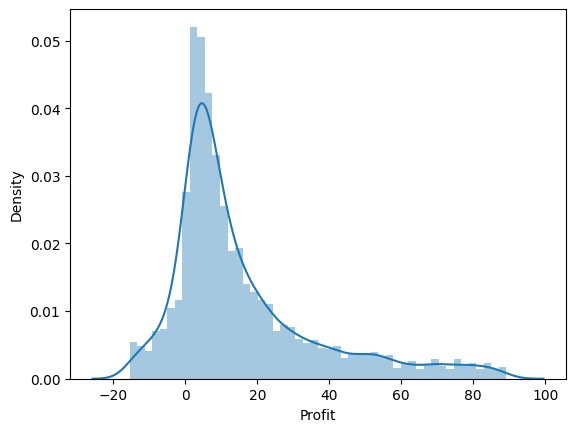

In [26]:
#Checking for outliers
sns.distplot(df_cleaned["Profit"]);
plt.savefig("Profit.png")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  


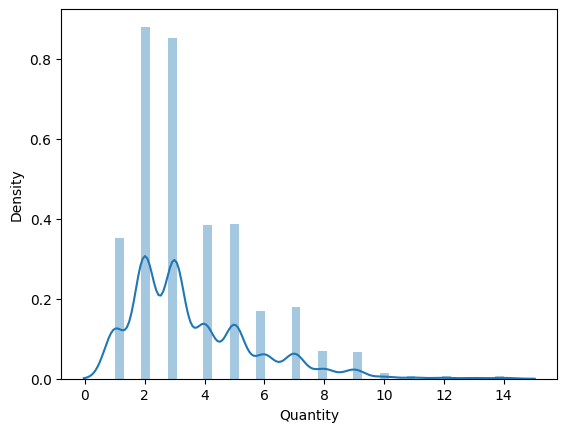

In [27]:
#Checking for outliers
sns.distplot(df_cleaned["Quantity"])
plt.savefig("Quantity.png")

## Create Vertex AI Dataset 

In [28]:
from google.cloud import aiplatform

aiplatform.init(project="tries-and-spikes", location="us-central1")

dataset = aiplatform.TabularDataset.create_from_dataframe(
    df_cleaned,
    display_name="ProductSales Cleaned",
    staging_path="bq://tries-and-spikes.tutorial.productsales-cleaned"
)

dataset.wait()

print(f'\tDataset: "{dataset.display_name}"')
print(f'\tname: "{dataset.resource_name}"')

Creating TabularDataset
Create TabularDataset backing LRO: projects/599225543291/locations/us-central1/datasets/4284856187070971904/operations/4569965255869857792
TabularDataset created. Resource name: projects/599225543291/locations/us-central1/datasets/4284856187070971904
To use this TabularDataset in another session:
ds = aiplatform.TabularDataset('projects/599225543291/locations/us-central1/datasets/4284856187070971904')
	Dataset: "ProductSales Cleaned"
	name: "projects/599225543291/locations/us-central1/datasets/4284856187070971904"


## Log your clean Dataset, add graphs attachments

In [29]:
from google.cloud import bigquery

bq_client = bigquery.Client()

prepared_ds = vectice.BigQueryResource("tries-and-spikes.tutorial.productsales-cleaned", df_initial, bq_client)


prepared_ds = vectice.Dataset.clean(
    name="ProductSales Cleaned",
    resource=prepared_ds,
    derived_from=origin_dataset,                #Origin Dataset for documenting the lineage
    attachments=["Profit.png", "Quantity.png"]  #Graphs attachments
)

In [30]:
prep_iteration.step_clean_data = prepared_ds 

New Version: 'Version 2' of Dataset: 'ProductSales Cleaned' added to Step: Clean data
Attachments: Quantity.png, Profit.png
Link to Step: https://app.vectice.com/browse/iteration/ITR-1247



### Log your "ProductSales Cleaned" dataset in your step "Clean Data"

In [ ]:
prep_iteration.complete()

## 🥇 Congrats! You learn how to succesfully use Vectice to auto-document the Data Preparation phase of the Tutorial Project.<br>
### Next we encourage you to explore other notebooks in the tutorial series. You can find those notebooks in Vectice public GitHub repository : https://github.com/vectice/GettingStarted/